# Cleaning

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importieren des Datensatzes
url = "https://raw.githubusercontent.com/ponkis01/BusinessAnalytics/refs/heads/main/WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(url)

In [60]:
# Einstellung um den ganzen datensatz zu sehen
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [61]:
# Nach fehlenden Daten suchen
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

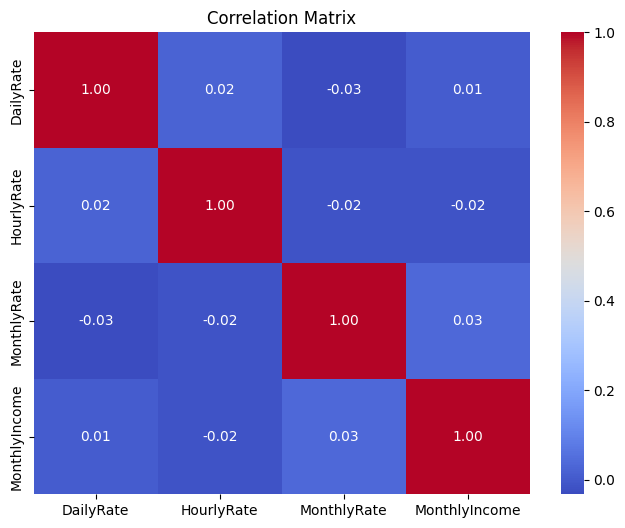

In [62]:
import seaborn as sns

# Identifizieren ob es eine Korrelation zwischen den verschiedenen Bezahlungen gibt gibt
# Falls es diese gibt könnte man die Bezahlung auch mit einer Variablen beschreiben um das Modell leichter interpretierbar zu machen
df2 = df[["DailyRate", "HourlyRate", "MonthlyRate", "MonthlyIncome"]]
correlation_matrix = df2.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

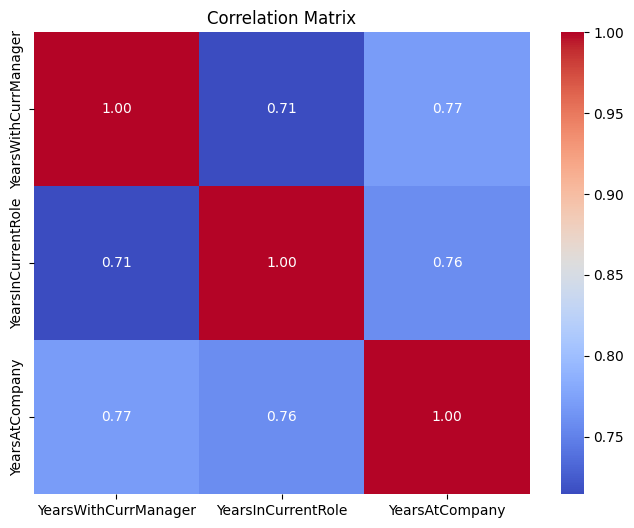

In [63]:
# Identifizieren ob es eine Korrelation zwischen YearsWithCurrManager, YearsInCurrentRole und YearsAtCompany gibt
# Da YearsAtCompany predicted wird wollen wir andere ähnlche und stark korrelierende Variablen löschen

df3 = df[["YearsWithCurrManager", "YearsInCurrentRole", "YearsAtCompany"]]
correlation_matrix = df3.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [64]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

# Droppen von Variable die nicht genutzt werden können
df = df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'YearsWithCurrManager', 'YearsInCurrentRole'], axis=1)

#Die Daten müssen verwertbar sein d.h. fehlerfrei und einheitlich formatiert sein
#Unnötige Daten werden entfernt
#Aufteilung in kategorische und numerische Spalten um diese später besser verarbeiten zu können

# Konvertieren von gewissen Variablen zu kathegorischen Variablen
categorical_columns = [
    'Attrition', 'BusinessTravel', 'Department', 'Education', 'Gender',
    'EducationField', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime',
    'StockOptionLevel', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction',
    'WorkLifeBalance'
]
df[categorical_columns] = df[categorical_columns].astype('category')

# Skalieren der numerischen Werte
variables_to_scale = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsSinceLastPromotion'
]
df_mean = df[variables_to_scale].mean()
df_std = df[variables_to_scale].std()
df[variables_to_scale] = (df[variables_to_scale] - df_mean) / df_std

# Encoden der kategorischen Variablen
# Hier weisen wir jedem kategorischen Wert eine Zahl zu. Das erlaubt den Modellen leichter mit den Variablen zu arbeiten
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['BusinessTravel', 'Department',
                     'EducationField', 'Gender', 'JobRole',
                     'MaritalStatus', 'OverTime', 'Over18', 'Attrition']
label_encoder = LabelEncoder()
for col in columns_to_encode:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')


# Strukturieren das Datensatzes in X und y (y Werte werden in einen strukturierten Array umgewandelt (Survival, Time)
event_column = df['Attrition'].astype(int)
time_column = df['YearsAtCompany']

# Da wir eine Survival analyse machen ist unser y Datensatz ein Array mit Überleben(ja/nein) und Überlebenszeit.
survival_data = Surv.from_arrays(event=event_column, time=time_column)
X = df.drop(['Attrition', 'YearsAtCompany'], axis=1)
y = survival_data

# Train und Test Aufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

y_train_event = y_train['event']
y_train_time = y_train['time']
y_test_event = y_test['event']
y_test_time = y_test['time']

# XGBoost

In [65]:
import xgboost as xgb
from sksurv.metrics import concordance_index_censored

# Initialisieren des Modells
xgb_model = xgb.XGBRegressor(
    enable_categorical=True,
    # Das objective erlaubt uns aus dem standart XGB Modell eine Cox Survival Analyse zu machen.
    objective='survival:cox',
)
xgb_model.fit(X_train, y_train_time, sample_weight=y_train_event)

# Vorhersagen der Train und Test Risikowerte
xgb_risk_scores_train = xgb_model.predict(X_train)
xgb_risk_scores_test = xgb_model.predict(X_test)

# Berechnen des Concordance Indexes
xgb_c_index_train = concordance_index_censored(y_train_event, y_train_time, xgb_risk_scores_train)[0]
xgb_c_index_test = concordance_index_censored(y_test_event, y_test_time, xgb_risk_scores_test)[0]

print(f"Concordance Index (Training): {xgb_c_index_train:.3f}")
print(f"Concordance Index (Testing): {xgb_c_index_test:.3f}")

Concordance Index (Training): 0.879
Concordance Index (Testing): 0.805


Der Concordance Index zeigt uns an, wie gut das Modell die Reihenfolge der "Überlebenszeiten" der verschiedenen Angestellten vorhersagt. Er sagt uns, wie gut das Modell in der Lage ist, für zwei beliebig ausgewählte Individuen die Rangfolge ihrer erwarteten Überlebenszeiten oder Risiken korrekt vorherzusagen. Ein Wert von 0.5 würde also aussagen dass das Modell keine Predictive Power hat und ein Wert von 1 dass das Modell alle Reihenfolgen richtig verhersagt.

# XGBSE

In [66]:
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index

# Initialisieren des Modells
xgbse_model = XGBSEKaplanNeighbors(enable_categorical = True)
xgbse_model.fit(X_train, y_train)

# Vorhersagen der Train und Test Risikowerte
xgb_risk_scores_train = xgbse_model.predict(X_train)
xgb_risk_scores_test = xgbse_model.predict(X_test)

# Berechnen des Concordance Indexes
xgb_c_index_train = concordance_index(y_train, xgb_risk_scores_train)
xgb_c_index_test = concordance_index(y_test, xgb_risk_scores_test)

print(f"Concordance Index (Training): {xgb_c_index_train:.3f}")
print(f"Concordance Index (Testing): {xgb_c_index_test:.3f}")

Concordance Index (Training): 0.904
Concordance Index (Testing): 0.777


/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/xgbse/non_parametric.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values


# Random Survival Forest

Das RSF Modell ist eine statistische Methode, welche Ereigniszeiten modelliert und versucht die Dauer bis zum eintreffen des Ereignisses vorherzusagen. Es basiert auf Bootstrap-Sampling (Datensatz ins zufällige Teile splitten), Baumerstellung (Baum splittet Daten basierend auf Überlebensinformationen und speichert diese in den Blättern) und Aggregation (Überlebenswahrscheinlichkeit eines neuen Datenpunkts wird als Durchschnitt der Vorhersagen aus allen Bäumen berechnet).
\
Im Endeffekt sagt der Random Survival Forest für jede Beobachtung eine Hazard-Kurve vorher. Diese kann in eine Survival-Kurve umgewandelt werden, die die Wahrscheinlichkeit angibt, dass ein Individuum über einen bestimmten Zeitpunkt hinaus überlebt.

In [67]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# Trainieren des Modells
rsf_model = RandomSurvivalForest()
rsf_model.fit(X_train, y_train)

# Vorhersagen der Trainings- und Testdaten
rsf_risk_scores_train = rsf_model.predict(X_train)
rsf_risk_scores_test = rsf_model.predict(X_test)

# Berechnen des C Indexes
rsf_c_index_train = concordance_index_censored(y_train['event'], y_train['time'], rsf_risk_scores_train)[0]
rsf_c_index_test = concordance_index_censored(y_test['event'], y_test['time'], rsf_risk_scores_test)[0]

print(f"Concordance Index (Training): {rsf_c_index_train:.3f}")
print(f"Concordance Index (Testing): {rsf_c_index_test:.3f}")

Concordance Index (Training): 0.972
Concordance Index (Testing): 0.832


Der Random Survival Forest schneidet ohne Tuning am besten von allen Modellen ab. Deswegen haben wir uns entschieden, mit diesem Modell weiterzuarbeiten.

# Tuning

Da GridSearchCV weder nach dem C-Index optimieren kann noch strukturierte Arrays als Zielvariablen unterstützt, müssen wir das Modell mit Hyperopt manuell optimieren.


In [68]:
from hyperopt import fmin, tpe, hp, Trials
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import KFold
import numpy as np

# Zielfunktion erstellen
def objective(params):
    # Erstellen des Random Survival Forest mit variablen Parametern
    model = RandomSurvivalForest(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']) if params['max_depth'] is not None else None,
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        random_state=12
    )

    # Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=12)
    c_index_scores = []

    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]

        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict(X_test_cv)

        c_index = concordance_index_censored(y_test_cv['event'], y_test_cv['time'], predictions)[0]
        c_index_scores.append(c_index)

    # Durchschnitt des Konkordanz-Index für alle CV Folds berechnen
    mean_c_index = np.mean(c_index_scores)

    # Hyperopt minimiert die Zielfunktion, also geben wir den negativen C-Index an
    return -mean_c_index

# Hyperparametergrid erstellen
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 500, 1000]),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 50]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

# Optimierung starten
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|████████| 50/50 [05:58<00:00,  7.18s/trial, best loss: -0.8694866941236683]


In [69]:
# Fitting des Modells mit optimalen Prametern
optimal_model = RandomSurvivalForest(
    n_estimators=[100, 200, 500, 1000][best['n_estimators']],
    max_depth=[None, 10, 20, 30, 50][best['max_depth']],
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    max_features=['sqrt', 'log2', None][best['max_features']],
    random_state=12
)
optimal_model.fit(X_train, y_train)
optimal_model.get_params()

{'bootstrap': True,
 'low_memory': False,
 'max_depth': 50,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}

# Evaluieren des Modells

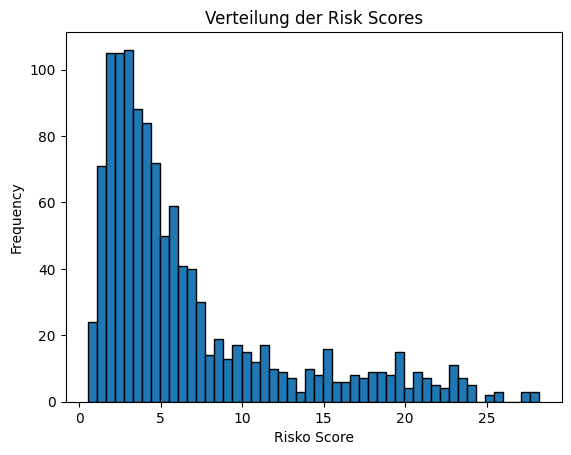

In [70]:
# Visualisieren der Verteilung der Risiko Scores
# Wir schauen uns die Riskiowerte an um zu entschieden ob es besonders hohe Werte gibt.
# Wenn man exp(Risikowert) berechnet erhält man das Hazard Ratio des Individuums relativ zum Baseline-Risiko
risk_scores = optimal_model.predict(X_train)
plt.hist(risk_scores, bins=50, edgecolor='k')
plt.title("Verteilung der Risk Scores")
plt.xlabel("Risko Score")
plt.ylabel("Frequency")
plt.show()

Unsere Risikowerte sind relativ hoch. Wir interpretieren daraus, dass es starke Unterschiede zwischen den Individuen gibt, die sich auf das Überlebensrisiko auswirken. \
Um zu prüfen, ob es Ausreißer in den Daten gibt, untersuchen wir die Individuen mit den höchsten Risikowerten.

In [71]:
X_test[rsf_risk_scores_test > 20]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsSinceLastPromotion
776,-1.852558,1,-0.082986,2,-0.023747,3,2,4,0,-0.584923,3,1,8,4,2,-0.887844,0.406292,-0.677819,0,1,-0.330477,3,2,0,-1.192630,0.155654,3,-0.678915
14,-0.976841,2,-1.733507,1,1.826536,3,1,3,1,-0.781682,2,1,2,3,2,-0.950504,-0.191928,0.923457,0,1,-0.330477,3,2,0,-0.678543,0.931286,3,-0.678915
177,-1.962023,2,-1.237855,1,-0.887213,3,1,2,1,-0.929252,2,1,2,4,2,-1.147192,-0.712596,-0.677819,0,0,1.855353,4,3,0,-1.321152,0.155654,2,-0.368590
149,-1.962023,2,0.938056,1,-0.763861,1,3,2,0,0.644821,3,1,2,2,2,-1.066265,0.251328,-0.677819,0,0,-0.330477,3,4,0,-1.321152,0.155654,3,-0.678915
301,-2.071487,2,0.023579,2,0.099605,3,3,4,0,0.152923,2,1,8,3,2,-1.126376,-0.644737,-0.677819,0,0,-0.876934,3,1,0,-1.449673,-0.619978,3,-0.678915
798,-0.429518,2,0.531622,1,1.949889,3,3,1,1,-0.535734,2,1,6,2,2,-0.889968,-1.590397,0.523138,0,1,1.308896,4,2,0,-0.807064,-2.171243,3,-0.058265
909,-1.962023,2,-1.332029,1,1.949889,3,1,2,0,-0.437354,4,1,6,4,2,-0.745319,0.970512,-0.677819,0,1,-0.876934,3,4,0,-1.321152,-0.619978,3,-0.678915
892,-1.962023,0,-0.739725,1,0.099605,3,3,1,0,1.481047,2,1,6,2,2,-0.986401,-1.147141,-0.677819,0,1,2.675039,4,2,0,-1.321152,-0.619978,4,-0.678915


Es gibt keine Besonderheiten oder extremen Werte bei Individuen mit hohen Risikowerten.

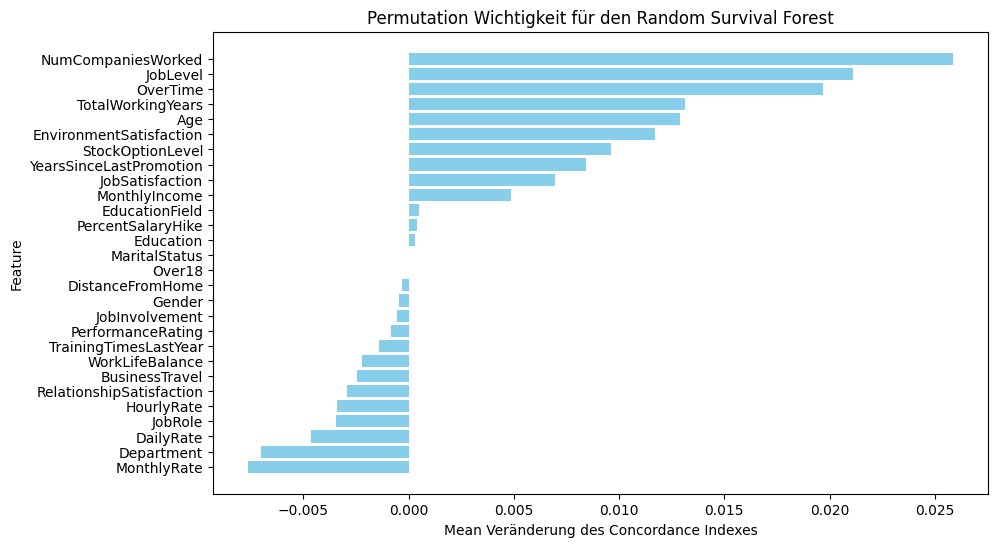

In [72]:
from sklearn.inspection import permutation_importance

# Bestimmen der Permutation Importances
perm_importance = permutation_importance(optimal_model, X_test, y_test, n_repeats=10, random_state=42)

# Erstellen einen Dataframes von Permutation und Importance
feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Erstellen des Permutation Importance Plots
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Mean Veränderung des Concordance Indexes")
plt.ylabel("Feature")
plt.title("Permutation Wichtigkeit für den Random Survival Forest")
plt.gca().invert_yaxis()
plt.show()

Im folgenden Teil versuchen wir, die vorhergesagte durchschnittliche Überlebenszeit des gesamten Testdatensatzes mit der tatsächlichen Überlebenszeit zu vergleichen.
\
Der Random Survival Forest schätzt lediglich eine Hazard-Funktion, die in eine Survival-Kurve umgewandelt werden muss.
\
Außerdem verfügen wir nicht über die direkte Überlebenszeit für alle Individuen im Datensatz, da viele noch bei IBM arbeiten. Deshalb müssen wir die durchschnittliche Überlebenszeit mithilfe des Kaplan-Meier-Fitters berechnen.

In [73]:
from lifelines import KaplanMeierFitter
import numpy as np

# Vorhersage der Überlebenskurven für jede Person im Test Datensatz
predicted_survival_curves = optimal_model.predict_survival_function(X_test)

# Berechnung der erwarteten Überlebenszeit für jede Person
expected_survival_times = []
for survival_curve in predicted_survival_curves:
    time_points = survival_curve.x
    survival_probs = survival_curve.y
    time_diffs = np.diff(np.append(0, time_points))
    expected_time = np.sum(survival_probs * time_diffs)
    expected_survival_times.append(expected_time)

# Berechnung der mean vorhergesagten Überlebenszeit
expected_survival_times = np.array(expected_survival_times)
predicted_mean_time = expected_survival_times.mean()
print(f"Vorhergesagte Mean Survival Time: {predicted_mean_time:.2f}")

# Kaplan Meier Schätzung (Fitter)
# Ist eine statistische Methode zur Schätzung der Überlebenswahrscheinlichtkeit (Eintreffen eines Ereignisses), über die Zeit.
# Wir benutzen diese Mehtode da mna nicht dirkt die beobachtete Überlebenszeit berechnen kann, da viele Angestellte noch im Unternehmen sind.
#  ->  Liefert eine Treppenfunktion, welche bei jedem Ereigniszeitpunkt abnimmt.
#  ->  Berücksichtigt zensierte Daten (Daten bei denen das Ereignis nicht im Beobachtungszeitraum eintritt) und entfernt diese aus der Berechnung.

# Anpassen des Kaplan-Meier-Modells an die Test Daten
kmf_test = KaplanMeierFitter()
kmf_test.fit(y_test_time, event_observed=y_test_event)

# Extraktion der ÜKaplan-Meier-bereinigten beobachteten mittleren Überlebenszeit
survival_probs = kmf_test.survival_function_.values.flatten()
time_points = kmf_test.survival_function_.index.values
time_diffs = np.diff(np.append(0, time_points))
adjusted_mean_time = np.sum(survival_probs * time_diffs)
print(f"Bereinigte Beobachtete Mean Survival Time: {adjusted_mean_time:.2f}")

Vorhergesagte Mean Survival Time: 29.82
Bereinigte Beobachtete Mean Survival Time: 27.17


Im folgenden Teil versuchen wir, die Survival Analysis als Klassifizierungsproblem umzugestalten. Dabei schauen wir, ob über einen gewissen Zeitraum die Angestellten tatsächlich im Unternehmen geblieben sind. Das Modell mithilfe des Kaplan Meier Fitters sagt gleichzeitig die Überlebenswahrscheinlichkeit für diesen Zeitraum aus. Bei einer Wahrscheinlichkeit von 0.5 und darüber wird also vorhergesagt, dass die Person überlebt. So können wir Metriken wie Accuracy etc. berechnen. Wir nehmen heirfür den ganzen Datensatz, da die Anzahl der Leute die das Unternehmen bereits verlassen, sowieso relativ klein ist, wäre es nicht sinnvoll sich auf den Testdatensatz zu beschränken.

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Spezifische Jahre definieren
time_points = [1, 2, 5]  # Zeitpunkte in Jahren
results = []

predicted_survival_curves_x = optimal_model.predict_survival_function(X)

for t in time_points:
    # Überlebenswahrscheinlichkeiten für den spezifischen Zeitpunkt berechnen
    predicted_probs_at_time = np.array([sf(t) for sf in predicted_survival_curves_x])

    # Maske für gültige Fälle
    # Jeder der t oder weniger Jahre im Unternehmen war und bereits gegangen ist.
    actual_status_at_time = np.where((y["time"] <= t) & (y["event"] == 0), 0, 1)
    # Über einer Wahrscheinlichkeit von 0.5 wird als survival und darunter als nicht survival klassifiziert
    actual_predictions = (predicted_probs_at_time >= 0.5).astype(int)

    # Berechnen der Scores
    accuracy = accuracy_score(actual_status_at_time, actual_predictions)
    precision = precision_score(actual_status_at_time, actual_predictions, zero_division=0)
    recall = recall_score(actual_status_at_time, actual_predictions, zero_division=0)

    results.append({
        "time": t,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
    })

# Anziegen der Resultate
for res in results:
    print(f"Time {res['time']} year(s): "
          f"Accuracy={res['Accuracy']:.2f}, "
          f"Precision={res['Precision']:.2f}, "
          f"Recall={res['Recall']:.2f}, ")

Time 1 year(s): Accuracy=0.89, Precision=0.91, Recall=0.97, 
Time 2 year(s): Accuracy=0.81, Precision=0.84, Recall=0.97, 
Time 5 year(s): Accuracy=0.53, Precision=0.56, Recall=0.89, 


Die Accuracy und die Precision des Modells starten mit guten Werten nehmen aber zunehmend ab, das Modell ist somit nur mäßig dafür geeignet Vorhersagen über längere Zeiträume zu treffen. Wobei der Recall relativ hoch bleibt, das Modell erkennt also die Personen die gehen wollen aber bewertet auch viele die nicht gehen wollen als positives, es gibt also viele falsche Positive.

# Verbesserung der Durchschnittsüberlebenszeit

In folgendem Teil suchen wir uns eine Person aus dem Trainingsdatensatz heraus. Für diese Person berechnen wir die vorhergesagte durchschnittliche Überlebenswahrscheinlichkeit und versuchen zu ermitteln, mit welchen Veränderungen von Variablen man eine längere durchschnittliche Überlebenswahrscheinlichkeit erzielen kann. Hierbei beschränken wir uns auf Variablen, die der Arbeitgeber verändern kann.

In [75]:
# Erstellen einer einzigen Observation (Person)
person_number = 1
person = X_train.iloc[[person_number]]
t_condition = y_train['time'][person_number]

In [76]:
  from lifelines import KaplanMeierFitter

  # Anpassen des Kaplan-Meier-Modells an die Trainings Daten
  kmf_train = KaplanMeierFitter()
  kmf_train.fit(y_train_time, event_observed=y_train_event)

  # Vorhersage des ursprünglichen Risikoscores und der Hazardratio
  original_risk_score = optimal_model.predict(person)
  original_hazard_ratio = np.exp(original_risk_score)

  # Extrahiere die Basis-Überlebenskurve
  baseline_times = kmf_train.survival_function_.index.values  # Zeitpunkte der Basis-Überlebensfunktion
  baseline_survival = kmf_train.survival_function_.values.flatten()

  # Erstellen einer Funktion umd dei verbeleibende Überlebenszeit zu berechnen -> für jede person die weitere Zeit im unternehmen
  def compute_conditional_expected_time(hazard_ratio, baseline_survival, baseline_times, t_condition):

      # Finden der Überlebenswahrscheinlichkeit bei t_condition
      idx_condition = np.searchsorted(baseline_times, t_condition, side="right") - 1
      survival_prob_at_t_condition = baseline_survival[idx_condition]

      # Passe die Überlebenswahrscheinlichkeiten der Basisfunktion mithilfe der Hazardratio des Individuums an
      adjusted_survival_probs = (baseline_survival / survival_prob_at_t_condition) ** hazard_ratio
      adjusted_survival_probs[baseline_times <= t_condition] = 0

      # Berechne die bedingte erwartete Überlebenszeit
      time_diffs = np.diff(np.append(0, baseline_times))
      conditional_expected_time = np.sum(adjusted_survival_probs * time_diffs)
      return conditional_expected_time

  # Anwenden der Funktion
  conditional_expected_survival_time = compute_conditional_expected_time(
      original_hazard_ratio, baseline_survival, baseline_times, t_condition
  )
  conditional_expected_survival_time

6.339684991925489

In [77]:
# Wir verändern jeweils eine Variable und schauen, wie sich das auf die durchschnittliche Überlebenszeit auswirkt.

# Beförderung: YearsSinceLastPromotion, JobLevel
person_higher_joblevel = person.copy()

person_higher_joblevel['JobLevel'] = person_higher_joblevel['JobLevel'].astype(int)
if (person_higher_joblevel['JobLevel'] != 5).any():
    person_higher_joblevel['JobLevel'] += 1
    person_higher_joblevel['YearsSinceLastPromotion'] = (0 - df_mean['YearsSinceLastPromotion']) / df_std['YearsSinceLastPromotion']
person_higher_joblevel['JobLevel'] = person_higher_joblevel['JobLevel'].astype('category')

changed_risk_score = optimal_model.predict(person_higher_joblevel)
changed_hazard_ratio = np.exp(changed_risk_score)

conditional_expected_survival_time_higher_joblevel = compute_conditional_expected_time(
    changed_hazard_ratio, baseline_survival, baseline_times, t_condition
)

# OverTime
person_no_overtime = person.copy()
person_no_overtime['OverTime'] = 0
person_no_overtime['OverTime'] = person_no_overtime['OverTime'].astype('category')

changed_risk_score = optimal_model.predict(person_no_overtime)
changed_hazard_ratio = np.exp(changed_risk_score)

conditional_expected_survival_time_no_overtime = compute_conditional_expected_time(
    changed_hazard_ratio, baseline_survival, baseline_times, t_condition
)

# Environment Satisfaction
person_higher_environment_satisfaction = person.copy()

person_higher_environment_satisfaction['EnvironmentSatisfaction'] = person_higher_environment_satisfaction['EnvironmentSatisfaction'].astype(int)
if (person_higher_environment_satisfaction['EnvironmentSatisfaction'] != 4).any():
    person_higher_environment_satisfaction['EnvironmentSatisfaction'] += 1
person_higher_environment_satisfaction['EnvironmentSatisfaction'] = person_higher_environment_satisfaction['EnvironmentSatisfaction'].astype('category')

changed_risk_score = optimal_model.predict(person_higher_environment_satisfaction)
changed_hazard_ratio = np.exp(changed_risk_score)

conditional_expected_survival_time_higher_environment_satsfaction = compute_conditional_expected_time(
    changed_hazard_ratio, baseline_survival, baseline_times, t_condition
)

# StockOptionLevel
person_higher_stockoption = person.copy()

person_higher_stockoption['StockOptionLevel'] = person_higher_stockoption['StockOptionLevel'].astype(int)
if (person_higher_stockoption['StockOptionLevel'] != 3).any():
    person_higher_stockoption['StockOptionLevel'] += 1
person_higher_stockoption['StockOptionLevel'] = person_higher_stockoption['StockOptionLevel'].astype('category')

changed_risk_score = optimal_model.predict(person_higher_stockoption)
changed_hazard_ratio = np.exp(changed_risk_score)

conditional_expected_survival_time_higher_stockoption = compute_conditional_expected_time(
    changed_hazard_ratio, baseline_survival, baseline_times, t_condition
)


# JobSatisfaction
person_higher_jobsatisfaction = person.copy()

person_higher_jobsatisfaction['JobSatisfaction'] = person_higher_jobsatisfaction['JobSatisfaction'].astype(int)
if (person_higher_jobsatisfaction['JobSatisfaction'] != 4).any():
    person_higher_jobsatisfaction['JobSatisfaction'] += 1
person_higher_jobsatisfaction['JobSatisfaction'] = person_higher_jobsatisfaction['JobSatisfaction'].astype('category')

changed_risk_score = optimal_model.predict(person_higher_jobsatisfaction)
changed_hazard_ratio = np.exp(changed_risk_score)

conditional_expected_survival_time_jobsatisfaction = compute_conditional_expected_time(
    changed_hazard_ratio, baseline_survival, baseline_times, t_condition
)
conditional_expected_survival_time_jobsatisfaction


def get_max_variable_name_from_values(**kwargs):
    max_variable = max(kwargs, key=kwargs.get)
    return max_variable
# Finden der längsten "Überlebenszeit"
max_variable = get_max_variable_name_from_values(
    no_overtime=conditional_expected_survival_time_no_overtime,
    higher_jobsatisfaction=conditional_expected_survival_time_jobsatisfaction,
    promotion=conditional_expected_survival_time_higher_joblevel,
    higher_environment_satisfaction=conditional_expected_survival_time_higher_environment_satsfaction,
    higher_stockoption_level=conditional_expected_survival_time_higher_stockoption
)

print(f"Veränderung für die längste Überlebenszeit: {max_variable}")

Veränderung für die längste Überlebenszeit: no_overtime


Leider trifft das Modell bei den meisten Personen die gleiche Aussage, und zwar, dass Overtime verringert werden soll. Wir haben dieses Tool also nicht mit auf die Website übernommen. Auf der Website kann man selbst die Variablen jeder Person anpassen und beobachten, wie sich dies auf die durchschnittliche Überlebenszeit auswirkt.

# Visualisierung der Survival Curve

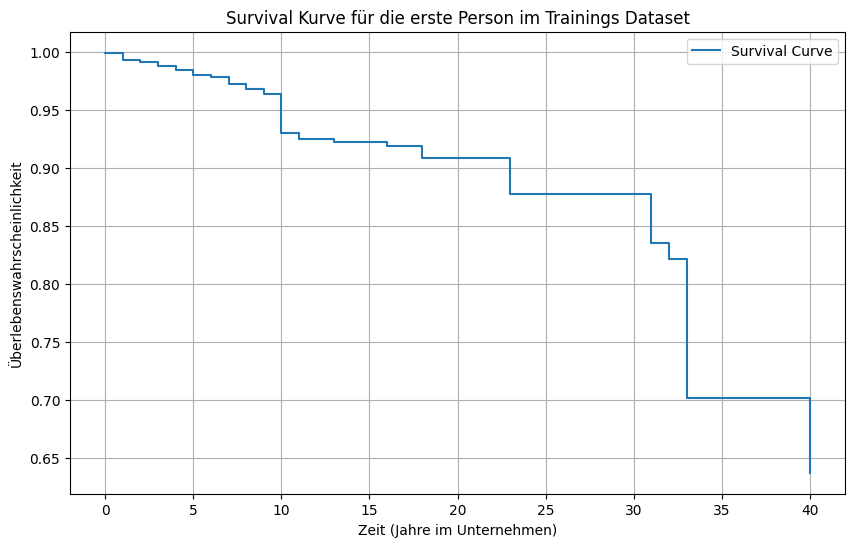

In [78]:
# Survival Funktion generieren
survival_function = optimal_model.predict_survival_function(person)

# Funktion plotten
plt.figure(figsize=(10, 6))
for fn in survival_function:
    plt.step(fn.x, fn.y, where="post", label="Survival Curve")

plt.title("Survival Kurve für die erste Person im Trainings Dataset")
plt.xlabel("Zeit (Jahre im Unternehmen)")
plt.ylabel("Überlebenswahrscheinlichkeit")
plt.grid(True)
plt.legend()
plt.show()

# Verbesserung des PerformanceRatings

Im folgenden Modell versuchen wir herauszufinden, wie man neben der Zeit im Unternehmen auch die Performance der Angestellten erhöhen kann.

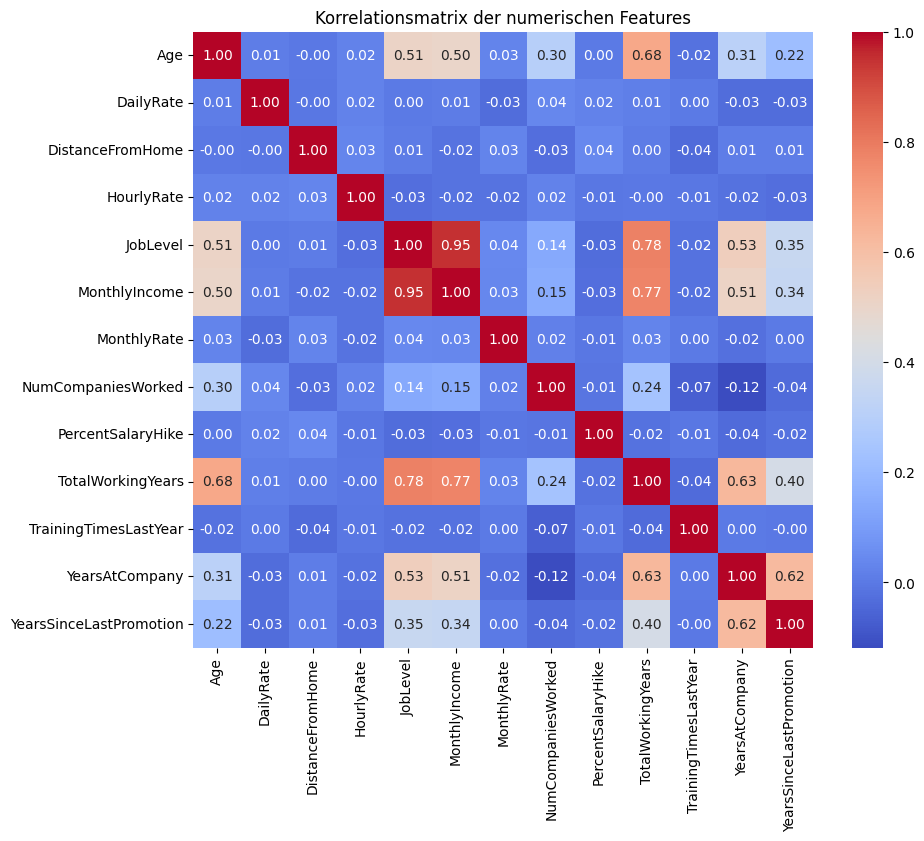

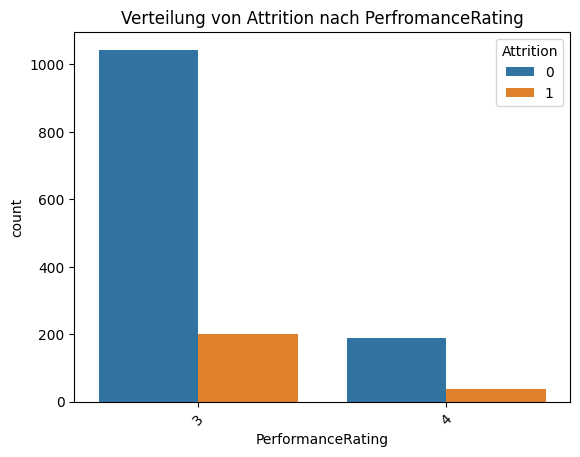

In [79]:
#Explorative Analyse der Variablen

# Korrelation von numerischen Variablen
numerical_features = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr()

# Visualisierung
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix der numerischen Features")
plt.show()


# Beispiel: Verteilung von Attrition nach PerformanceRating
sns.countplot(data=df, x='PerformanceRating', hue='Attrition')
plt.title("Verteilung von Attrition nach PerfromanceRating")
plt.xticks(rotation=45)
plt.show()


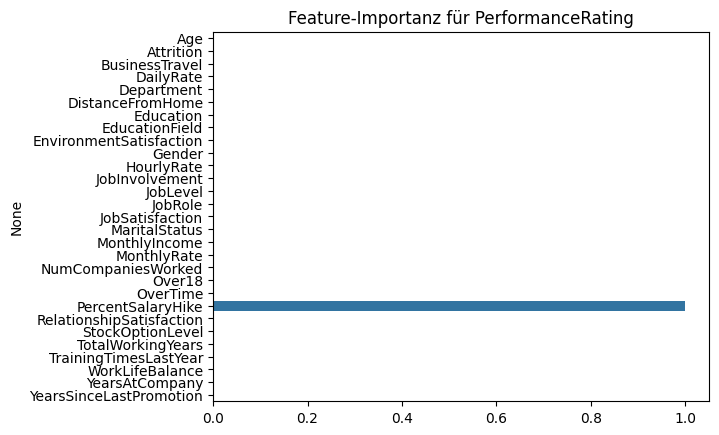

In [80]:
# Regressionsmodell für performanceRating

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Zielvariablen
X = df.drop(['PerformanceRating'], axis =1)
y_performance = df['PerformanceRating']

# Daten aufteilen (z. B. für PerformanceRating)
X_train, X_test, y_train, y_test = train_test_split(X, y_performance, test_size=0.3, random_state=42)

# Modell für Performance trainieren (z. B. Random Forest Regressor)
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Feature-Importanz
importances = regressor.feature_importances_
features = X.columns

# Visualisierung
sns.barplot(x=importances, y=features)
plt.title("Feature-Importanz für PerformanceRating")
plt.show()

Mean Squared Error: 0.0
R²-Wert: 1.0


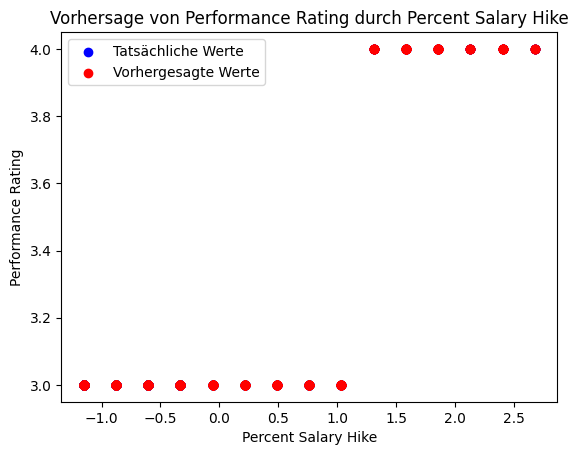

Feature Importances:  [1.]
Der erforderliche Salary Hike für PerformanceRating 4 ist: 1.1749267578125


/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/vincentklaer/miniforge3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature nam

In [81]:
#Das Modell soll zeigen wie performanceRating durch percentsalaryhike vorhergesagt wird.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Angenommen, df ist dein DataFrame und PerformanceRating ist die Zielvariable
X = df[['PercentSalaryHike']]
y = df['PerformanceRating']

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modell trainieren
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Vorhersage
predictions = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, predictions)  # Mean Squared Error
r2 = r2_score(y_test, predictions)  # R²-Wert

# Ausgabe der Modellbewertung
print(f"Mean Squared Error: {mse}")
print(f"R²-Wert: {r2}")

# Visualisierung der Vorhersagen vs. tatsächliche Werte
plt.scatter(X_test, y_test, color='blue', label='Tatsächliche Werte')
plt.scatter(X_test, predictions, color='red', label='Vorhergesagte Werte')
plt.xlabel('Percent Salary Hike')
plt.ylabel('Performance Rating')
plt.title('Vorhersage von Performance Rating durch Percent Salary Hike')
plt.legend()
plt.show()

# Feature-Importanz anzeigen
importances = model.feature_importances_
print("Feature Importances: ", importances)


# Funktion, die die Vorhersage für ein bestimmtes percentsalaryhike berechnet
def predict_performance_rating(salary_hike):
    return model.predict([[salary_hike]])[0]

# Optimierung: Findet den percentsalaryhike, der PerformanceRating 4 erreicht
def find_salary_hike_for_rating(target_rating):
    low, high = 0, 100  # Annahme, dass der percentsalaryhike zwischen 0 und 100 liegt
    tolerance = 0.01

    while high - low > tolerance:
        mid = (low + high) / 2
        predicted_rating = predict_performance_rating(mid)

        if predicted_rating < target_rating:
            low = mid
        else:
            high = mid

    return (low + high) / 2

# Finde den percentsalaryhike, der PerformanceRating 4 ergibt
required_salary_hike = find_salary_hike_for_rating(4)
print(f"Der erforderliche Salary Hike für PerformanceRating 4 ist: {required_salary_hike}")
